# User behavior insights - case study

## Data structure

Each row in the dataset represents one pageview for a user (identified by the `user_id`). 
The whole customer journey can be traced through the timestamps, the session number as well as the `page_id`, which is a consecutive number per user/session for the pages they visited. The `pagepath` reveals the actual page type the user was on. If the page type identifies a hotel (e.g., offerlist, hotel/media etc.) we also provide the respective `hotel_uuid` identifier.


A booking is indicated by the `transaction` pagepath. The given `hotel_uuid` identifies the booked hotel then.

## Task

The solution should include at least 2-3 insights that we can talk about in the technical interview. It doesn't need to be comprehensive, we're more interested in your approach and how you would derive business insights than in the actual results.

## Setup 

In [1]:
# load libraries
import numpy as np
import pandas as pd
import sys, time

# determine the path to the source folder 
pth_to_src = 'C:/DEV/Clickstream_case_study/'

## Define utility functions 

In [2]:
# Define utility functions (i.e., additional auxillary python functions) for later usage:

# Alternatively: store utility functions in separate script and load them 
# sys.path.append(pth_to_src+'utils/')
# from utility import plot_rel_freq, plot_rel_freq_by_group, get_description, plot_distribution

def plot_rel_freq(df, var_name,  title = 'Relative frequency', top_x = None):
    """
    Plot relative frequencies of a variable 
    :param df: (dataframe) containing data to be used for ploting.
    :param var_name: (string) name of variable to compute relative frequencies of.
    :param title: (string) title to be printed on the plot.
    :param top_x: (integer) if not None: Number of most common variable values to be considered in plot.
    :output: (None)
    """ 
    # get the number of cases for each distict value of var_name in the dataframe df:
    dfg = pd.DataFrame(df.groupby([ var_name ]).size(), columns = [ var_name ]); dfg.index.name ='Index' 
    # compute the relative frequencies:
    dfg /=dfg.sum()
    if not top_x is None:
        # order the grouped table by ascending order of the var_name variable:
        dfg = dfg.sort_values(dfg.columns[0],ascending=False)
        # select the top_x entries:
        dfg = dfg.loc[dfg.index[0:(top_x-1)],:]
    # plot the result    
    dfg.plot(kind='bar',title=title, ylabel='Relative frequency')
        
    
def plot_rel_freq_by_group(df, var_name, group_var_name, title = 'Relative frequency', top_x = None, custom_order = None):
    """
    Plot relative frequencies of a variable per group
    :param df: (dataframe) containing data to be used for ploting.
    :param var_name: (string) name of variable to compute relative frequencies of.
    :param group_var_name: (string) name of variable to group by.
    :param title: (string) title to be printed on the plot.
    :param top_x: (integer) if not None: Number of most common variable values to be considered in plot.
    :custom_order: (list) if not None: a user-defined list to order the grouped outcome.
    :output: (None)
    """
    # get the number of cases for each distict value of a var_name and group_name combination in the dataframe df:
    dfg = df.groupby([ var_name, group_var_name ]).size().unstack() 
    # compute the relative frequencies:
    dfg /=dfg.sum()
    # use a user-defined list to order the grouped table
    if not custom_order is None:
        dfg = dfg.reindex(custom_order)       
    if not top_x is None:
        # order the grouped table by ascending order of the var_name variable
        dfg = dfg.sort_values(dfg.columns[0],ascending=False)
        # select the top_x entries:    
        dfg = dfg.loc[dfg.index[0:(top_x-1)],:]
    # plot the result      
    dfg.plot(kind='bar',title=title, ylabel='Relative frequency')

    
def get_description(df, var_name):
    """
    Get the statistical description of a variable for booking and non-booking users.
    :param df: (dataframe) containing data to be analysed.
    :param var_name: (string) name of variable to be described.
    :output df1: (dataframe) containing the statistical description of the variable var_name for booking and non-booking users.
    """  
    # remove duplicate observations per user:
    df1 = df[['user_id',var_name,'is_buyer']].drop_duplicates()
    # create the output data frame:
    df1 = pd.DataFrame({'Booking users':df1.loc[df1.is_buyer==1,var_name].describe(), 'Non-booking users': df1.loc[df1.is_buyer==0,var_name].describe()})
    return df1    


def plot_distribution(df, var_name, group_var_name = None, title = ''):
    """
    Create distribution plots of a variable 
    :param df: (dataframe) containing data to be used for ploting.
    :param var_name: (string) name of variable to compute relative frequencies of.
    :param group_var_name: (string) if not None: name of variable to group by.
    :param title: (string) title to be printed on the plot.
    :output: (None)
    """   
    import matplotlib.pyplot as plt
    import seaborn as sns    
    fig = plt.figure(figsize=(12, 6))
    plt.title(title)
    if not group_var_name is None:
        df.groupby(df.index.get_level_values(group_var_name))[var_name].apply(
            lambda x: sns.kdeplot(x, label=x.name))
        plt.legend(loc='best')
    else:
        ax = sns.displot(df[var_name],kde=True,rug=True)
    plt.xlabel(var_name)
    plt.ylabel('kernel density estimation')
    plt.show()

## Read the data

In [3]:
# Read the dataframe:
df = pd.read_csv(pth_to_src+'data/userbehavior.csv',  parse_dates=['timestamp'], infer_datetime_format=True)

In [4]:
# sort dataframe according to 'user_id','session_id','timestamp','page_id' in ascending order.
# Doing so (re)ensures that the dataframe is the expected order and lines are in a sequential order.
df = df.sort_values(['user_id','session_id','timestamp','page_id'])
# reset the index:
df = df.reset_index()

## Add additional variables

In [5]:
# Add a variable to indicate a booking action:
df['booked']= 1*(df.page_name=='transaction')

In [6]:
# Add a variable to indicate the day of the week:
df['weekday'] = df['timestamp'].dt.day_name() 

In [7]:
# Add a variable to indicate the hour of the day:
df['hour'] = df['timestamp'].dt.hour

## Describe the data overall briefly

In [8]:
# describe the dataframe briefly
print('The dataframe has %d rows and %d columns.'% df.shape)
print('First rows of the dataframe:')
print(df.head())
print('\nColumns of dataframe:')
print(df.columns)

The dataframe has 3297196 rows and 11 columns.
First rows of the dataframe:
     index                       user_id  session_id           timestamp  \
0  3239084  ++3HPCLueAkaMjet8R9BNe3D90g=           1 2022-02-02 11:35:19   
1  3239085  ++6W7NF0RJB5aoqbpgjbFi+Tk2U=           1 2022-02-27 20:52:27   
2  3239086  ++6W7NF0RJB5aoqbpgjbFi+Tk2U=           1 2022-02-27 20:52:39   
3  3239087  ++6W7NF0RJB5aoqbpgjbFi+Tk2U=           1 2022-02-27 20:53:11   
4  3239090  ++6W7NF0RJB5aoqbpgjbFi+Tk2U=           1 2022-02-27 20:53:44   

    device  page_id     page_name                            hotel_uuid  \
0  desktop        1  /forum/topic                                   NaN   
1   mobile        1         /home                                   NaN   
2   mobile        1         /home                                   NaN   
3   mobile        2    /hotellist                                   NaN   
4   mobile        3    /offerlist  66562c02-f746-37b3-acce-1702beb8fe5d   

   booked    wee

In [9]:
# dataframe description:
print('Number of users:            %d'% len(df.user_id.unique()))
print('Number of session_ids:      %d'% len(df.session_id.unique()))
print('Number of devices:          %d'% len(df.device.unique()))
print('Number of page_ids:         %d'% len(df.page_id.unique()))
print('Number of page_names:       %d'% len(df.page_name.unique()))
print('Number of hotel_uuid:       %d'% len(df.hotel_uuid.unique()))    
print('First timestemp:            %s'% df.timestamp.min())  
print('Last timestemp:             %s'% df.timestamp.max()) 
print('Considered time period:     %s'% str(df.timestamp.max() - df.timestamp.min())) 
print('Number of bookings:         %d'% sum(df.booked))  
print('Number of users who booked: %d'% len(df[df.booked==1].user_id.unique()))  
print('\n')

Number of users:            20380
Number of session_ids:      896
Number of devices:          3
Number of page_ids:         1456
Number of page_names:       443
Number of hotel_uuid:       16198
First timestemp:            2022-02-01 00:00:00
Last timestemp:             2022-02-28 23:59:59
Considered time period:     27 days 23:59:59
Number of bookings:         9497
Number of users who booked: 8744




In [46]:
# overall conversion rate
print('Overall conversion rate:            :'+  str(round(len(df[df.booked==1].user_id.unique())/len(df.user_id.unique()) ,3)) )

Overall conversion rate:            :0.429


In [48]:
for i in np.unique(df.device):
    cvr_i = len(df.loc[(df.device==i) & (df.booked==1),'user_id'].unique())/len(df.loc[df.device==i,'user_id'].unique())
    print('Conversion rate for '+i+'            :'+  str(round(cvr_i,3)) )

Conversion rate for desktop            :0.6
Conversion rate for mobile            :0.24
Conversion rate for tablet            :0.402


## Understand the data structure more deeply 

### Is the data set unique per user, session, timestamp and page id combination?

#### Analysis

In [10]:
# get unique data set  per user, session, timestamp and page id combination
df1 = pd.DataFrame(df.groupby(['user_id','session_id','timestamp','page_id']
).agg('size'))
df1.reset_index(inplace=True)

In [11]:
print('Number of rows in the full data set:   %d. \nNumber of rows in unique data set:     %d.  \nAre both data sets of the same length: %s.'%(len(df), len(df1), len(df1)==len(df)))

Number of rows in the full data set:   3297196. 
Number of rows in unique data set:     2740823.  
Are both data sets of the same length: False.


#### Conclusion

No, the data set is not unique per user, session, timestamp and page id combination.

### Why is the data set not unique per user, session, timestamp and page id combination?

#### Analysis

In [12]:
print('Number of non-unique rows: %d (per user, session, timestamp and page id combination).'%sum(df1[0]>1))

Number of non-unique rows: 273282 (per user, session, timestamp and page id combination).


In [13]:
print('Examples of non-unique rows (per user, session, timestamp and page id combination):')
df1.loc[df1.index[df1[0]>1],:]

Examples of non-unique rows (per user, session, timestamp and page id combination):


,user_id,session_id,timestamp,page_id,0
7,++6W7NF0RJB5aoqbpgjbFi+Tk2U=,1,2022-02-27 20:53:49,3,2
10,++6W7NF0RJB5aoqbpgjbFi+Tk2U=,1,2022-02-27 20:54:36,4,2
13,++6W7NF0RJB5aoqbpgjbFi+Tk2U=,1,2022-02-27 20:54:44,5,5
17,++6W7NF0RJB5aoqbpgjbFi+Tk2U=,1,2022-02-27 20:55:26,7,2
34,++aQdeHnI6Sj71QMj8vsqzV5LUU=,3,2022-02-27 19:05:45,6,2
...,...,...,...,...,...
2740785,zytuflFuJXiO5TFPSLoBFLwxWJ0=,2,2022-02-18 17:45:37,38,4
2740786,zytuflFuJXiO5TFPSLoBFLwxWJ0=,2,2022-02-18 17:45:38,38,2
2740787,zytuflFuJXiO5TFPSLoBFLwxWJ0=,2,2022-02-18 17:45:39,38,4
2740794,zytuflFuJXiO5TFPSLoBFLwxWJ0=,2,2022-02-18 17:46:38,41,4


In [14]:
# clean workspace
del df1

In [15]:
# pick an example of non-unique rows to review it further in detail 
print('Data of example of non-unique rows (per user, session, timestamp and page id combination):')
df[(df["user_id"]=='++i4iUzUtbf2GFsphbv1ZN81ieo=' )& (df["session_id"]==22) & (df["timestamp"] == '2022-02-22 10:49:08')]

Data of example of non-unique rows (per user, session, timestamp and page id combination):


,index,user_id,session_id,timestamp,device,page_id,page_name,hotel_uuid,booked,weekday,hour
695,3237418,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,d4f08d1f-22a6-3b66-bf74-f15a41c7a979,0,Tuesday,10
696,3237421,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,5fd59f56-87e6-4b57-acfc-0c27d7a23299,0,Tuesday,10
697,3237422,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,58a74c25-d55b-3886-a066-0578a985394a,0,Tuesday,10
698,3237423,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,58a74c25-d55b-3886-a066-0578a985394a,0,Tuesday,10
699,3237426,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,5fd59f56-87e6-4b57-acfc-0c27d7a23299,0,Tuesday,10
700,3237427,++i4iUzUtbf2GFsphbv1ZN81ieo=,22,2022-02-22 10:49:08,desktop,14,/offerlist,58a74c25-d55b-3886-a066-0578a985394a,0,Tuesday,10


#### Conclusion

There can be multiple rows in the data set per user, session, timestamp and page id combination. 
For example in the case different hotels or the same hotel are listed several times on the same offlist page.

## User activity

### User activity per device type

#### Analysis

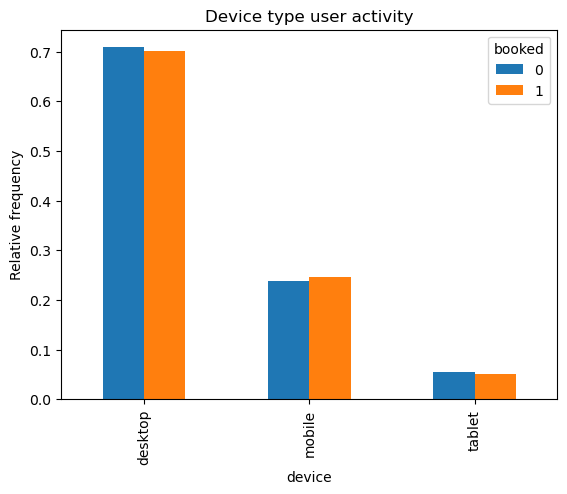

In [16]:
# Create frequency plot of user activity per device type and grouped by booking user activity and non-booking user activity:
plot_rel_freq_by_group(df, 'device', 'booked', title='Device type user activity')

#### Assumption

There are no structural technical differences of how clickstream data is produced per device type.

#### Conclusion

1. Desktop is by far the most common device type, mobile is also often used and tablet less often but still noticeably often.
1. There is no device type that is predominately used for booking or browsing behavior (without-booking).

### User activity per page type

#### Analysis

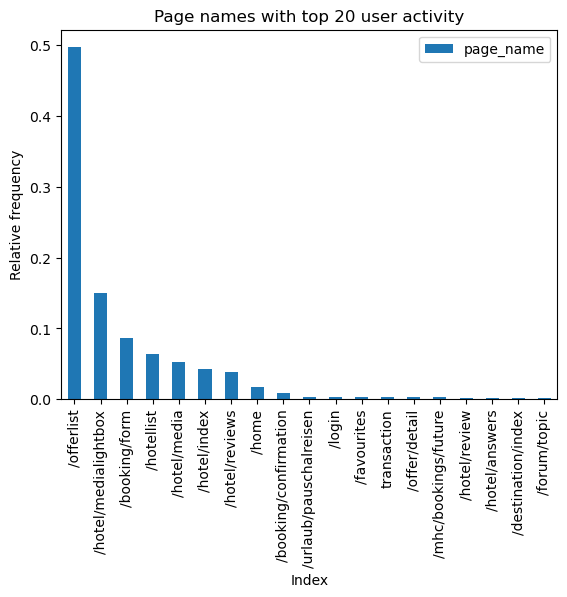

In [17]:
# Create frequency plot of user activity per pages types (page name). 
# We consider here only the top 20 most used page types due to their relevance and for a concise representation of the results.  
plot_rel_freq(df, 'page_name', title='Page names with top 20 user activity', top_x = 20)

#### Conclusion

Offerlist is with almost 50% the by far most common page type / page name.
The top 8 page names represent roughly 90% of cumulative frequency of all page names.
There is however a long tail of seldom appearing page names (400+).

### User activity per hotel

#### Analysis

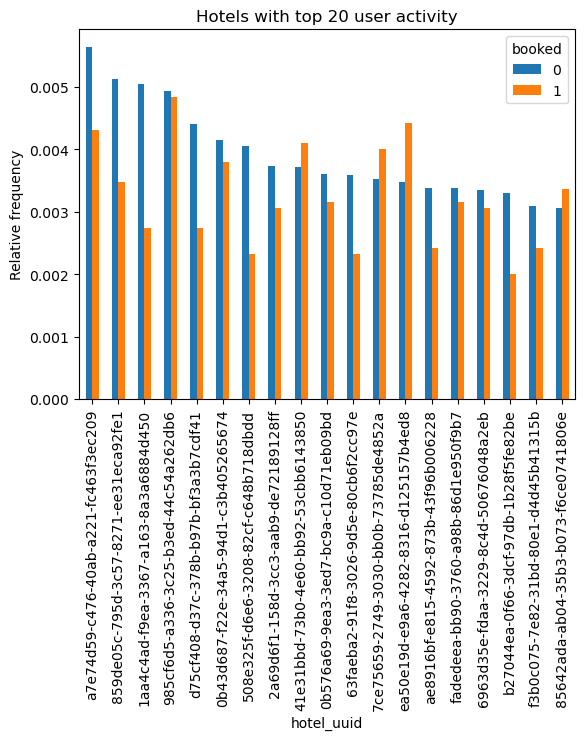

In [18]:
# Create frequency plot of user activity per hotel (hotel uuid) and grouped by booking user activity and non-booking user activity.
# We consider here only the top 20 most frequent hotels due to their relevance and for a concise representation of the results.  
plot_rel_freq_by_group(df, 'hotel_uuid', 'booked', title='Hotels with top 20 user activity', top_x = 20)

#### Conclusion

1. The most common hotels appear relatively similar often and their overall frequency is relatively low. __This indicates that there no domoninating hotels that are appearing all the time compared to others.__
1. We see that some hotels have a relatively higher (or lower) frequency of booking compared the browsing behavior (without-booking) of users on their pages. __This means that these hotels perform relatively well (worse) in converting users compared to other hotels.__

#### Possible further analysis

Find the, e.g., top 20 hotels where the __gap between the relative frequency of browsing (without booking) and booking is the highest__ or higher than a threshold. 
These hotel offerings have a __high potential__ and it is worthwhile to __indentify what is blocking__ them to be better at converting users.<br>
Similarly, find the, e.g., top 20 hotels where the __gap between the relative frequency of booking and browsing (without booking) is the highest__ or higher than a threshold. 
These hotel offerings have are __overforming__ and it is worthwhile to identify what is makeing them excel at converting users.

#### Possible business strategy implications

1. __Offer__ the hotels with __high potential__ (automatic) __recommendations__ what to do to increase conversion.
1. __Support__ __overforming__ hotels to __incease their reach and attract more users__ (e.g., increase their visibilty in the offerlist or grant them a special icon on the hotel detail page or on their offerlist representation)

### User activity per day of the week

#### Analysis

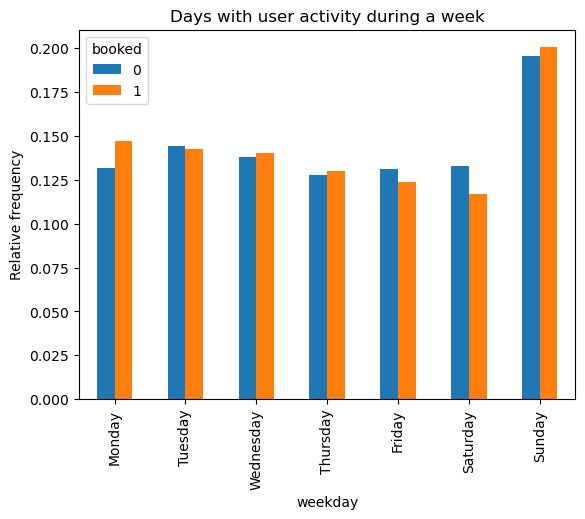

In [19]:
# Create frequency plot of user activity per day of the week and grouped by booking user activity and non-booking user activity.
plot_rel_freq_by_group(df, 'weekday', 'booked', title='Days with user activity during a week', custom_order= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

#### Conclusion

Sunday is the most important day in a week for both, booking and browsing (without-booking). The other days are relatively similar important for booking and browsing (without-booking). Whereas, Saturday  is relatively more important for browsing (without-booking) and Monday for booking.

#### Possible business strategy implications

1. __Support__ users to make __booking__ decision __on Friday and Saturday__ (e.g., relaxed cancellation policy, reservation). 
1. Foster __Sunday as peak browsing and booking day__ (e.g., with special offers, new deals, newsletter posts, external advertising).
1. Support __Monday as booking day__ (e.g., with special last minute promotions or deals).

### User activity per hour of the day

#### Analysis

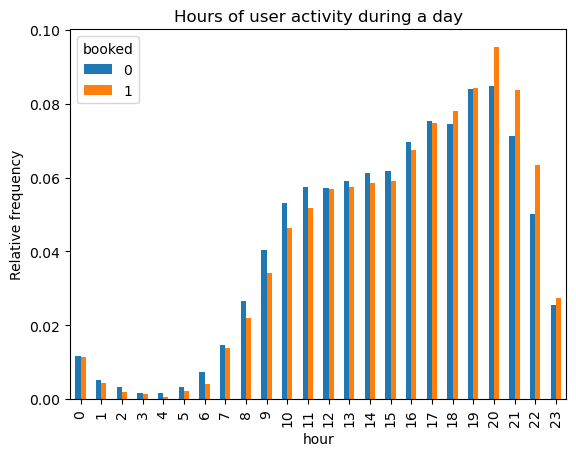

In [20]:
# Create frequency plot of user activity per hour of the day and grouped by booking user activity and non-booking user activity.
plot_rel_freq_by_group(df, 'hour', 'booked', title='Hours of user activity during a day')

#### Conclusion

1. __Booking and browsing (without-booking)__ of users increase strongly from 6 am to 11 am, are constantly high from 11 am to 3 pm, and __peak from 4 pm to 9 pm, with the highest peak at 8pm.__
1. There is a tendency for relatively __more browsing (without-booking) during the earlier hours of a day__ (until 5 pm) and a relatively __more booking during the later hours of a day (until 11 pm)__.

#### Possible business strategy implications

1. __Support__ users to make __booking__ decision __earlier during the day__ (e.g., with short time offers and reservation with booking with same day cancellation). 
1. Foster __peak time and later hours booking__ (e.g., with late day special offers and deals until the end of day).

## Customer journey

### Add additional customer journey related metrics

In [21]:
# Add indicator variable whether observation is before the first booking of a user:
df['is_before_first_booking'] = (df.groupby(['user_id'])['booked'].cumsum() == 0 ) * 1

In [22]:
# Add indicator variable whether a user booked at least once:
df['is_buyer'] = df.groupby(['user_id'])['booked'].transform(max) 

### Consideration period

#### Definition

The consideration period is defined here as the time from the first observed activity of a user until his first booking. <br> 
For non-booking users, it is the time from first activity of the user until his last observed activity.<br>
The consideration period represents the window of opportunity in which a user forms the purchase decision and in which the booking platform and hotel offerings have a chance to convert the user to book.

#### Assumptions

1. The user __activity data is complete__ and there is __n__o relevant user activity __outside__ the booking platform website and the __dataset__ under consideration. 
1. We __ignore__ the fact that the __dataset__ under consideration __has a beginning and an end__. Both can shorten the compute consideration period and we may find, e.g., that users who did not book in the time period of the dataset under consideration may book later, etc.
1. User __activity can be tracked__ and also, e.g., across days and browsing activity sesssions. 

In the case the assumptions from above are violated, the __measured consideration period__ is __shorter than__ the __actual one__.

#### Analysis

In [23]:
# Add variable for the consideration period until first booking:
time0 = df['timestamp'][0]
# initialize the consideration_period variable
df['consideration_period'] = df['timestamp']
# set timestamps after the first booking to NaN to ignore them subsequently:
df.loc[(df['is_before_first_booking'] ==0) & (df['is_buyer']==1),'consideration_period'] = np.NaN
# compute the consideration period until first booking
df['consideration_period'] = df.groupby(['user_id'])['consideration_period'].transform(lambda x: x.max() - x.min()+time0)-time0

In [24]:
# print the statistics:
get_description(df,'consideration_period')

,Booking users,Non-booking users
count,8744,11636
mean,2 days 13:36:59.185269899,1 days 03:27:32.555345479
std,4 days 22:15:39.681867542,3 days 21:08:14.871832788
min,0 days 00:00:46,0 days 00:00:00
25%,0 days 00:25:17.500000,0 days 00:00:00
50%,0 days 01:40:57.500000,0 days 00:01:44
75%,2 days 19:22:34,0 days 00:19:52
max,27 days 04:29:22,27 days 11:46:16


In [25]:
# get rate of buyers from users with consideration period of 1 day or longer:
df1 = df[['user_id','consideration_period','is_buyer']].drop_duplicates()
df1.loc[df1.consideration_period >='1 days','is_buyer'].mean()

0.667693661971831

In [26]:
# get rate of non-booking users with consideration period of 1 day or longer:
np.mean(df1[df1.is_buyer==0].consideration_period >='1 days') 

0.12976968030250946

#### Conclusion

1. We see that the __consideration period is highly skewed__: There many booking users who have a relatively short consideration period but others with a considerable long period. We find this when comparing the relatively large mean value and small median value (or the big difference between the 25% and the 75% quartile).
1. The __consideration period for non-booking__ users is overall __very short__. 
1. __67%__ of users with a __consideration period of one day or longer are booking__. __13% of the non-booking users__ have a consideration period of one day or more. This indicates a __potential__ for converting these users.

#### Possible business strategy implication

Use __re-marketing__, etc. to support users who did not convert on the first day but have an consideration period above a certain threshold (e.g., 1 day).

### Dwell time on pages

#### Definition

Dwell time on pages is defined as the time a user spends on website pages with a given page id.
This is, it consists of the time a user is browsing, booking and collecting information about hotel offerings.
Dwell time represents a measure of the information need a user has to complete the booking decision.

#### Assumptions

1. __Analogous__ to the ones from __above__ for the consideration period.
1. __Multi-tab browsing__ does __not influence__ the correctness of the data under consideration.
1. Differences of __page rendering__ times are the same for all page types and/or __can be ignored__.

#### Analysis

In [27]:
# Add variable for the dwell time until first booking:
time0 = df['timestamp'][0]
# initialize the dwell_time variable
df['dwell_time'] = df['timestamp']
# set timestamps after the first booking to NaN to ignore them subsequently:
df.loc[(df['is_before_first_booking'] ==0) & (df['is_buyer']==1),'dwell_time'] = np.NaN
# compute the dwell time per session:
#df['dwell_time_session'] = df.groupby(['user_id','session_id'])['dwell_time'].transform(lambda x: x.max() - x.min()+time0)-time0
dwell_time_session = df.groupby(['user_id','session_id'])['dwell_time'].agg(lambda x: x.max() - x.min()+time0)-time0

In [28]:
# compute the dwell time per user:
dwell_time_user = pd.DataFrame(dwell_time_session.groupby(['user_id']).sum()); dwell_time_user.columns = ['total_dwell_time']; dwell_time_user.reset_index(inplace=True)

In [29]:
# insert the dwell time per user into the dataframe df: 
df = pd.merge(df,dwell_time_user, left_on=['user_id'], right_on=['user_id'], how='inner')

In [30]:
# print the statistics:
get_description(df,'total_dwell_time')

,Booking users,Non-booking users
count,8744,11636
mean,0 days 01:28:26.156107044,0 days 00:11:32.701701615
std,0 days 02:13:44.950759102,0 days 00:43:10.613271162
min,0 days 00:00:41,0 days 00:00:00
25%,0 days 00:20:34,0 days 00:00:00
50%,0 days 00:45:22,0 days 00:01:18
75%,0 days 01:39:32.250000,0 days 00:07:26.250000
max,2 days 00:29:02,1 days 01:44:56


#### Conclusion

1. We see that the __dwell time is somewhat skewed__: There some booking users who have a shorter dwell time period but others with longer dwell times. We find this when comparing the mean and median values (or the difference between the 25% and the 75% quartile).
1. The __dwell time for non-booking__ users is overall __very short__. Even the 75% quartile of the dwell time of non-booking users is only 7 minutes, and therefore lower than the 25% quartile of the dwell time of booking users.


#### Possible business strategy implication

Support __(non-booking) users to stay longer on the website__. 1. __Investigate why__ these users spend only a short amount of time on the website via further analysis of the clickstream data (cf. section "Further analyses" below) or, e.g., via an online survey. 2. __Remove blockers__ so that users spend more time browsing.

### Viewed Hotels

#### Definition

The number of viewed hotels is defined as the number of distinct hotel ids appearing in a user's clickstream data set from the first activity of the user until his first booking. <br> 
For non-booking users, it is the number of distinct hotel ids appearing in a user's clickstream data set from the first activity of the user until his last observed activity.<br>
The number of viewed hotels represents the consideration set of hotels offerings a user considers to form his purchase decision to book or not to book.

#### Assumptions

1. __Analogous to__ the ones from __above__ for the consideration period.
1. The __user noticed and considered each appearing hotel__ in his clickstream dataset.

#### Analysis

In [31]:
# add distinct viewed hotels until first booking:
# initialize the viewed_hotels variable
df['viewed_hotels'] = df['hotel_uuid']
# set hotels after the first booking to NaN to ignore them subsequently:
df.loc[(df['is_before_first_booking'] ==0) & (df['is_buyer']==1),'viewed_hotels'] = np.NaN
# compute the viewed_hotels until first booking
df['viewed_hotels'] = df.groupby(['user_id'])['viewed_hotels'].transform(lambda x: len(x.unique()))

In [32]:
# print the statistics:
get_description(df,'viewed_hotels') 

,Booking users,Non-booking users
count,8744.000000,11636.000000
mean,7.362420,2.417927
std,11.819627,5.655613
min,2.000000,1.000000
25%,2.000000,1.000000
50%,3.000000,1.000000
75%,8.000000,2.000000
max,201.000000,231.000000


#### Conclusion

1. We see that the __number of viewed hotels is somewhat skewed__: There some booking users who have a lower number of viewed hotels but others a higher number of viewed hotels. We find this when comparing the mean and median values (or the difference between the 25% and the 75% quartile).
1. The __number of viewed hotels for non-booking__ users is overall __lower__. The 75% quartile of the number of viewed hotels of non-booking users is only 2.

#### Possible business strategy implication

__Support (non-booking) users to consider more hotel offerings__. 1. __Investigate why__ these users do not consider more hotel offerings via further analysis of the clickstream data (cf. section "Further analyses" below) or, e.g., via an online survey. 2. __Remove blockers__ so that users increase the number of considered hotel offerings.

### Further possible analyses 

1. __Plot the empirical distribution__ of the _consideration period, dwell time and viewed hotels_ using, e.g., the function plot_distribution. <br> Doing so will help to gain a deeper understanding of how frequent certain values of a variable are and therefore, e.g., how similar or different the activity behavior is across users. 
1. __Break the path information from the page_name variable down__ to possibly identify different page types and analyze the user activity on them, such as possibly the following: hotel detail pages, hotel review pages, hotel Q&A pages, image views, etc. <br> Doing so would allow to add new aspects to the customer journey and better understand user behavior and needs.

## Further possible analyses

### Path analysis of customer Journey

Examples of questions to address:
- _Which are common paths_ of users on their way to booking? 
- Are there _different paths for different users_?
- What are the _transition probabilities_ for the different stages in the user paths and where are _bottlenecks_?

### Analyze repeat bookers 

Examples of questions to address:
- _Why_ do they book several hotels? 
- Do they _spend overall_ more than one-time hotel bookers?
- If so, _what can we learn from them_ (e.g., from their hotel choices) to support one-time hotel bookers to book several hotels?